# Titanic Prediction of Survivers - Dataset: Kaggle

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("train.csv")
df_sub = pd.read_csv("test.csv")

## Checking Correlations

                  Age  Survived
Pclass      -0.369226 -0.338481
Age          1.000000 -0.077221
SibSp       -0.308247 -0.035322
PassengerId  0.036847 -0.005007
Parch       -0.189119  0.081629
Fare         0.096067  0.257307
Survived    -0.077221  1.000000


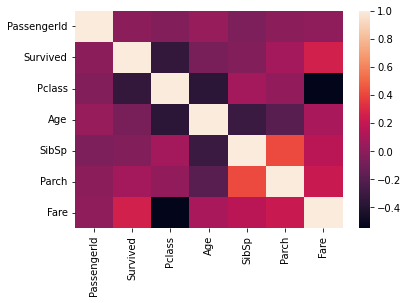

In [16]:
corr = df.corr()
sns.heatmap(corr)
print(corr[["Age","Survived"]].sort_values(by="Survived")) #look for correlations

## Data Cleaning

In [17]:
NUMERICAL = ["PassengerId", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Survived", "Pclass"]
CATEGORIAL = ["Name", "Embarked", "Sex", "Title"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [18]:
def clean(dataframe):
        
    dataframe["duplicate"] = dataframe.duplicated() # remove duplicates
    dataframe = dataframe.drop(dataframe[dataframe["duplicate"]==True].index)
    
 

    #dataframe = dataframe.drop(dataframe[dataframe["Sex"]].index) # removed 1 invalid Datapoint Sex=29.XXXXX
    
    dataframe = dataframe.drop(dataframe[~dataframe["Embarked"].isin(["S", "C", "Q"])].index) # removed 3 Datapoints nan from Embarked

    # create feature => "Title" from "Name"
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    dataframe["Title"] = dataframe["Name"].str.extract(" ([A-Za-z]+)\.", expand=True)

    dataframe['Title'] = dataframe['Title'].replace('Mlle', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Ms', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Mme', 'Mrs')

    dataframe.loc[~dataframe["Title"].isin(titles.keys()), "Title"] = "Rare" 
    dataframe["Title"] = dataframe["Title"].map(titles)

    for cat in CATEGORIAL: # Encode Categoricals
        le = preprocessing.LabelEncoder()
        dataframe[cat] = le.fit_transform(dataframe[cat])
    
    for pclass in dataframe["Pclass"].unique(): # Für NaN Alter: Mean der Pklassen (da höchste Korrelation)
        mean_age = int(dataframe.loc[dataframe["Pclass"]==pclass, "Age"].mean())
        std_age = int(dataframe.loc[dataframe["Pclass"]==pclass, "Age"].std())
        mean_fare = int(dataframe.loc[dataframe["Pclass"]==pclass, "Fare"].mean())
        std_fare = int(dataframe.loc[dataframe["Pclass"]==pclass, "Fare"].std())

        dataframe.loc[((dataframe["Age"].isnull()) & (dataframe["Pclass"]==pclass)), "Age"] = random.gauss(mean_age, std_age) # gauss for normal distribution
        dataframe.loc[((dataframe["Fare"].isnull()) & (dataframe["Pclass"]==pclass)), "Fare"] = random.gauss(mean_fare, std_fare)
    
    # Alternativ: fill Nan Age with mean
    #dataframe[dataframe["Age"].isnull()] = dataframe["Age"].mean()
    
    dataframe = dataframe.drop(columns=["Cabin", "Name", "Ticket", "duplicate"])
    
    return dataframe

df = clean(df)
df_sub = clean(df_sub)

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,0.649044,28.010923,0.524184,0.382452,32.096681,1.535433,0.726659
std,256.998173,0.486260,0.834700,0.477538,15.151818,1.103705,0.806761,49.697504,0.792088,1.030273
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,0.000000,16.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,26.000000,0.000000,0.000000,14.454200,2.000000,0.000000
75%,668.000000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,4.000000


### Feature "Sex" might be important?

<AxesSubplot:xlabel='Sex', ylabel='Count'>

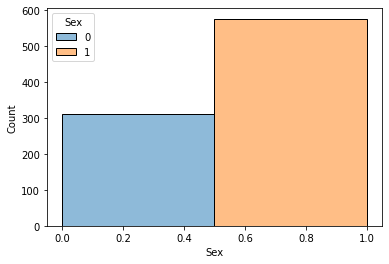

In [22]:
df_survived = df[["Sex", "Survived"]].copy()
sns.histplot(data=df_survived, x="Sex", hue="Sex", bins=2)

## Train Models

# SVM with train_test-split

In [62]:
X = df.drop(columns=["Survived"]).copy()
y = df["Survived"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


clf_svm_tts = svm.SVC(kernel="linear", C=1)
clf_svm_tts.fit(X_train, y_train)
y_pred = clf_svm_tts.predict(X_test)
pred_dict = {}
pred_dict["SVM_TTS"] = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.7865168539325843


## SVM with Cross Val

In [63]:
clf_svm_cv = svm.SVC(kernel='linear', C=1) # Support Vector Classifier
scores = cross_val_score(clf_svm_cv, X, y, cv=10) # 5 consecutive Times
pred_dict["SVM_CV"] = scores.mean()
print(scores.mean())

0.8064989785495402


## Random Forrest with train_test-split

In [9]:
clf_rdf_tts = RandomForestClassifier(n_estimators=100, max_depth=3, criterion="gini")
clf_rdf_tts.fit(X_train, y_train)
y_pred = clf_rdf_tts.predict(X_test)
pred_dict["RDF_TTS"] = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

NameError: name 'accuracy_score' is not defined

## Random Forrest with Cross Val

In [8]:
clf_rdf_cv = RandomForestClassifier(n_estimators=100, max_depth=3, criterion="gini")
scores = cross_val_score(clf_rdf_cv, X, y, cv=10)
pred_dict["RDF_CV"] = scores.mean()
print(scores.mean())

NameError: name 'RandomForestClassifier' is not defined

In [66]:
clf_dtc_tts = DecisionTreeClassifier()
clf_dtc_tts.fit(X_train, y_train)
y_pred = clf_dtc_tts.predict(X_test)
scores = accuracy_score(y_test, y_pred)
pred_dict["DTC_TTS"] = scores
print(scores)

0.7696629213483146


In [67]:
clf_lr_tts = LogisticRegression()
clf_lr_tts.fit(X_train, y_train)

y_pred = clf_lr_tts.predict(X_test)
score = accuracy_score(y_test, y_pred)
pred_dict["LR_TTS"] = score
print(score)

0.7696629213483146


C:\Users\Nhamm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
pred_results = pd.DataFrame({"Model": pred_dict.keys(), "Score": pred_dict.values()})
pred_results.sort_values(by="Score", ascending=False).set_index("Model").head()

,Score
Model,
RDF_CV,0.818935
SVM_CV,0.806499
RDF_TTS,0.797753
SVM_TTS,0.786517
DTC_TTS,0.769663


In [72]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf_rdf_tts.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.388
Sex,0.285
Pclass,0.120
Fare,0.095
SibSp,0.031
Age,0.030
PassengerId,0.022
Embarked,0.017
Parch,0.011


# Stick to best Model for: Random Forrest => write Upload-CSV

In [35]:
X_train = df[["Title", "Sex", "Pclass", "Fare", "SibSp", "Age", "PassengerId"]].copy() #leaving out "Embarked" & "Parch" to avoid Overfitting
y_train = df["Survived"].copy()
X_test = df_sub[["Title", "Sex", "Pclass", "Fare", "SibSp", "Age", "PassengerId"]].copy()

clf_rdf_cv = RandomForestClassifier(n_estimators=100, max_depth=3, criterion="gini")
clf_rdf_cv.fit(X_train, y_train)
y_pred = clf_rdf_cv.predict(X_test)

print(y_pred)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0]


In [37]:
df_rdy = pd.DataFrame()
df_rdy["PassengerId"] = df_sub["PassengerId"].copy()
df_rdy["Survived"] = y_pred
df_rdy.to_csv("submit.csv", index=False)
